# Estimation des pluies en Guyane

Ce framework a pour objectif d'évaluer différentes estimation de la pluviométrie en Guyane
Les sources des données utilisées sont :
- vérité terrain MétéoFrance
- images de température de brillance SSMIS produit par la NSIDC (API_NSIDC)
- images de température de surface SEVIRI produit par meteosat (API_METEOSAT)
- estimation IMERG produit par la NASA et JAXA (API_IMERG)
  
Les changements principaux à effectuer dans le code sont marqués par le mot clé TODO, dans la deuxième partie de code

## imports

In [1]:
# reloading 
%load_ext autoreload
%autoreload 2

# importing librairies
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta, timezone
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import interp1d, Rbf
from scipy.optimize import curve_fit
import random
import pandas as pd
import json
import sys
import os

# modules du répertoire courant
from classification import classification
import ground_truth_rain as gt

# modules du répertoire Images
sys.path.insert(0, r'../Images')
from Image import Image,compute_var
from File import File
from Geotiff_Format import Geotiff_Format

# modules du répertoire tools
sys.path.insert(0, r'../tools')
from tools import get_index,save_index,make_directory

# modules des répertoires des API 
sys.path.insert(0, r'API_METEOSAT')
from meteosat_download import download_SEVIRI_image
sys.path.insert(0, r'API_NSIDC')
from SSMIS_download import download_SSMIS_image
sys.path.insert(0, r'API_IMERG')
from IMERG_download import download_IMERG_image

## Initialisation des variables principales

On définit les chemins d'accès principaux afin d'obtenir les variables utiles dans tout le code

In [2]:

##### variables principales     #################################################################

# TODO : chemin d'accès au dossier principal où les fichiers seront générés
main_dir = make_directory(r"../../data/estimation_rain")

# TODO : chemin d'accès au fichier json contenant les paramètres de la projection comme la résolution et l'emprise
projection_path = r"../../data/param_proj/param_guy.json"

# TODO : chemin d'accès au fichier csv contenant la vérité terrain
gt_fn = r"../../data/pluie_sol/gauges_guyane_1h_utc.csv"

##### gestion de l'index        #################################################################

# l'index est un fichier json ou dictionnaire contenant pour chaque date les images correspondantes
# il est utile pour télécharger et combiner les images d'une même date

# TODO : remplir le chemin d'accès au fichier json index
index_path = main_dir + r"/acq_dates.json"

# TODO : Pour compléter les dates visées dans le format suivant
target_dates = [
    "2020-05-03T12:00:00.000000+0000",
    "2020-05-08T12:00:00.000000+0000",
    "2020-05-15T12:00:00.000000+0000",
    "2020-05-18T12:00:00.000000+0000",
    "2020-05-26T12:00:00.000000+0000",
    "2020-12-12T12:00:00.000000+0000",
    "2020-12-29T12:00:00.000000+0000"
]

# TODO : si l'index est utile à l'utilisation et qu'il n'est pas déjà mis en place,
# décommenter les 2 lignes ci-dessous pour l'initialiser

#index = {d.split(" ")[0]:{"target":d} for d in target_dates} # initialisation des clés de l'index
#save_index(index,index_path)   

##### clés de téléchargement        #################################################################

# TODO : pour le téléchargement des images
# remplir le chemin d'accès aux fichiers contenant les clés des API
path_API_meteosat_keys = r"../../data/keys/eds.key"         # deux lignes : voir meteosat pour les clés d'accès
path_API_nsidc_keys = r"../../data/keys/mdp_NSIDC.json"     # {"username": "<username>","password": "<password>}"

# TODO : vérifier si besoin les variables suivantes
##### initialisation des variables  #################################################################

# chemin d'accès aux métadatas de la vérité terrain
gt_mtd_fn = os.path.dirname(gt_fn) + r"/gauges_guyane_metadata.csv"

# chemins d'accès aux dossiers où seront téléchargés les fichiers bruts 
# la taille de ces fichiers peut devenir assez importante, notamment pour les images SEVIRI
SSMIS_src_dir = make_directory(r"../../data/SSMIS/download")
SEVIRI_src_dir = make_directory(r"../../data/SEVIRI/download")
IMERG_src_dir = make_directory(r"../../data/IMERG/download")

# chemins d'accès aux dossiers où seront téléchargés les fichiers reprojetés
SSMIS_proj_dir  = make_directory(main_dir + r"/SSMIS")
SEVIRI_proj_dir = make_directory(main_dir + r"/SEVIRI")
rr_dir          = make_directory(main_dir + r"/rain_rate")
agr_dir         = make_directory(main_dir + r"/agregation")
seg_dir         = make_directory(main_dir + r"/classification")
eval_dir        = make_directory(main_dir+r"/evaluation")

# chargement de la projection
projection = json.load(open(projection_path, "r", encoding="utf-8")) 

# format principal des dates
format = "%Y-%m-%dT%H:%M:%S.%f%z"

# permet de rechercher les images SSMIS par itération sur différents paramètres
SSMIS_parameters = { 
        "freq":     ["91V",         "91V",          "91V",          "91V"       ],
        "passage":  ["E",           "A",            "E",            "A"         ],
        "capteur":  ["F17_SSMIS",   "F17_SSMIS",    "F16_SSMIS",    "F16_SSMIS" ],
        "algo":     ["GRD",         "GRD",          "GRD",          "GRD"       ],
        "grid":     ["N25km",       "N25km",        "N25km",        "N25km"     ]
        }

## Téléchargement des images par l'index

L'index est un dictionnaire permettant d'accéder les chemins vers les différentes images par date, ce module permet de télécharger certaines images à partir des dates données dans l'index et de mettre celui-ci à jour

### Pour les images SSMIS

In [3]:
def download_SSMIS(attribute):
    """
    Télécharge les données SSMIS, puis réalise leur extraction et leur projection
    Les dates choisies sont les clés de l'index (variable globale index_path)
    Un fichier déjà présent dans le dossier SSMIS_src_dir n'est pas téléchargé à nouveau
    La recherche se fait par itérations sur certains paramètres (variable globale SSMIS_parameters) 
    L'index est automatiquement mis à jour
    
    Args:
        attribute (string) : attribut à extraire de l'image
    """
    index = get_index(index_path)
    for d in index.keys(): # pour chaque date dans le
        # téléchargement des données
        tg_date = datetime.strptime(d,format)
        retour = download_SSMIS_image(tg_date,SSMIS_src_dir,projection,SSMIS_parameters,path_API_nsidc_keys)
        tg_freq = SSMIS_parameters["freq"][0]
        if retour: # un fichier a bien été téléchargé
            src_filename,start_date,end_date = retour
            file = File(src_filename) ; string_d = d[:10]
            tif_filename = SSMIS_proj_dir + rf"/SSMIS_{attribute}_{tg_freq}_{string_d}.tiff"
            file.project(projection,attribute,out_path=tif_filename) # projection
            # inscription des chemins d'accès à l'index
            index[d][f"SSMIS_src_{tg_freq}"] = src_filename
            index[d][f"start_date_{tg_freq}"] = datetime.strftime(start_date,format)
            index[d][f"end_date_{tg_freq}"] = datetime.strftime(end_date,format)
            index[d][f"SSMIS_tif_{tg_freq}"] = tif_filename
            save_index(index,index_path)
        else:
            print(f"aucun fichier n'a été trouvé pour la date {d}")
        

### Pour les images SEVIRI

In [35]:
def download_SEVIRI(attribute):
    """
    Télécharge les données SEVIRI, puis réalise leur extraction et leur projection
    Un fichier déjà présent dans le dossier SEVIRI_src_dir n'est pas téléchargé à nouveau
    L'index est automatiquement mis à jour
    
    Args:
        attribute (string) : attribut à extraire de l'image
        SEVIRI_parameters (dict) : dictionnaire contenant les paramètres successifs à prendre en compte dans le téléchargement
    """
    nb_files_per_period = 12
    index = get_index(index_path)
    arrays_SEVIRI = []
    for d in index.keys():
        index[d]["IR_SEVIRI_source_files"] = []
        print(f"recherche pour la date {d}")
        start_acq_date = datetime.strptime(index[d]["start_date_91V"],format)
        end_acq_date = datetime.strptime(index[d]["end_date_91V"],format)
        delta = timedelta(seconds=(end_acq_date - start_acq_date).total_seconds() / nb_files_per_period)
        researched_dates = [start_acq_date + i*delta for i in range(nb_files_per_period)]
        for res_d in researched_dates:
            # téléchargement des données
            retour = download_SEVIRI_image(res_d,SEVIRI_src_dir,path_API_meteosat_keys)
            if retour: # un fichier a bien été téléchargé
                src_filename,start_date,end_date = retour
                index[d]["IR_SEVIRI_source_files"] = index[d]["IR_SEVIRI_source_files"] + [src_filename]
                SEVIRI_file = File(src_filename)
                img_proj = SEVIRI_file.project(projection,attribute)
                arrays_SEVIRI.append(img_proj.array)
        img_proj_agreg = Image(np.mean(np.array(arrays_SEVIRI),axis=0),img_proj.lons,img_proj.lats)
        string_d = d[:10]
        tif_filename = SEVIRI_proj_dir + rf"/SEVIRI_TB_{attribute}_{string_d}.tiff"
        img_proj_agreg.save(projection,tif_filename)
        index[d][f"SEVIRI_tif_{attribute}"] = tif_filename
        save_index(index,index_path)

### mise en place

In [ ]:
#download_SEVIRI("IR_108")
#download_SSMIS("TB")

## Agrégation des images par l'index

Il est alors possible d'agréger les images conservées dans l'index

In [3]:
def agregation_geotiff(out_dir,key,mode="mean"):
    """
    premet d'agréger les images correspondantes à toutes les dates contenues dans l'index 

    Args:
        out_dir (string) : chemin vers le répertoire de sortie
        key (string) : clé de l'image à agréger
        mode ("mean" ou "sum") : mode d'agrégation (Default "mean")

    Return:
        img_output (Image) : Image agrégée
    """
    arrays = []
    index = get_index(index_path)
    for d in index.keys(): # récupération des images
        try:
            file = File(index[d][key])
            if file.format != Geotiff_Format:
                print("le fichier doit être en format Geotiff")
                raise
            img = file.getImage(1)
            arrays.append(img.array)
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")
    
    lons,lats = img.lons, img.lats
    if mode == "mean":
        output = np.nanmean(np.array(arrays),axis=0)
    else:
        output = np.sum(np.array(arrays),axis=0)
    img_output = Image(output, lons, lats)
    img_output.save(projection,out_dir + rf"/{key}_agreg.tiff")
    return img_output


In [98]:
# test unitaire

for key in ["SSMIS_tif_91V","SEVIRI_tif_IR_087"]:
    img_agreg = agregation_geotiff(agr_dir,key)
img_var_IR = img_agreg.computeVar()
img_var_IR.save(projection,agr_dir + rf"/{key}_agreg_var.tiff")

## Extraction pixels de image - vérité terrain

Ce module permet de mettre en relation une image ou plusieurs avec la vérité terrain.

C'est à dire d'extraire les valeurs des capteurs sur le pixel correspondant

In [3]:
def combine_gt_pixel_from_image(filename,attribute,cols=False):
    """
    Pour une image et pour les capteurs séléctionnés
    associe la valeur du pixel correspondant à la localisation du capteur 
    et renvoie les listes contenant ces valeurs

    Args:
        filename (string) : nom du fichier dont on veut extraire les données
        attribute (float) : attribut de l'image à extraire
        cols (bool, list) : liste des index des stations à prendre en compte, les considère toutes si False (Default False)
    
    Return:
        final_df (pandas dataframe) : dataframe contenant les valeurs extraites
    """

    # initialisation du dataframe contenant le résultat
    final_df = pd.DataFrame()

    # récupération de l'image associée au fichier et des dates d'acquisition
    file = File(filename)
    image = file.project(projection,attribute)
    start_date,end_date = file.getAcqDates()

    # récupération de la vérité terrain et agrégation
    gt_1h_df = pd.read_csv(gt_fn)
    mtd_df = pd.read_csv(gt_mtd_fn)
    gt_1h_extr_df = gt.extract(gt_1h_df,start_date,end_date)
    
    if isinstance(gt_1h_extr_df, pd.DataFrame):
        gt_agreg_df = gt_1h_extr_df.sum(skipna=True,min_count=1)
    else:
        gt_agreg_df = gt_1h_extr_df

    # mise en place des colones à parcourir
    if cols == False:
        cols = gt_1h_df.columns[1:]
    elif type(cols[0]) == int:
        cols = [gt_1h_df.columns[col_idx] for col_idx in cols]

    # pour chaque station on associe la valeur du pixel à l'agrégation des mesures sur la période d'acquisition
    for col in cols:
        num = mtd_df.loc[mtd_df["Numéro"]==int(col)]["Numéro"].array[0]
        name = mtd_df.loc[mtd_df["Numéro"]==int(col)]["Nom"].array[0]
        lat = mtd_df.loc[mtd_df["Numéro"]==int(col)]["lat"].array[0]
        lon = mtd_df.loc[mtd_df["Numéro"]==int(col)]["lon"].array[0]
        lats, lons = image.lats.T[0], image.lons[0]
        idx_lat,idx_lon = (np.abs(lats - lat)).argmin(), (np.abs(lons - lon)).argmin()
        pixel_value = image.array[idx_lat][idx_lon] ; true_rain_value = gt_agreg_df.loc[col]
        if (not np.isnan(true_rain_value)) and (not np.isnan(pixel_value)):
            # vérification que l'une des valeur n'est pas nulle (manque de donnée par exemple)
            df = pd.DataFrame(columns=["date","nom capteur","id capteur","lon","lat","VT","pixel"])
            df.loc["total"] = [start_date,name,num,lon,lat,true_rain_value,pixel_value]
            final_df = pd.concat([final_df,df],ignore_index=True)

    return final_df


def combine_gt_pixel_from_index(key,attribute=1,sdk="start_date",edk="start_date",cols=False):
    """
    Pour une certaine image de chaque date de l'index, et pour les capteurs séléctionnés
    associe la valeur du pixel correspondant à la localisation du capteur 
    et renvoie les listes contenant ces valeurs

    Args:
        key (string) : clé correspondant à l'image dont on veut extraire les données
        attribute (int or string) : attribut de l'image à extraire (Default 1)
        sdk (string) : start date key, correspond à la clé indiquant le début de la période d'acquisition de l'Image
        edk (string) : end date key, correspond à la clé indiquant la fin de la période d'acquisition de l'Image
        cols (bool, list) : liste des index des stations à prendre en compte, les considère toutes si False (Default False)
    
    Return:
        final_df (pandas dataframe) : dataframe contenant les valeurs extraites
    """
    final_df = pd.DataFrame()
    index = get_index(index_path)
    true_rain_sample,pixel_values_sample = [],[]
    for d in index.keys():
        try:
            file = File(index[d][key])
            result_df = combine_gt_pixel_from_image(file,attribute,cols)
            final_df = pd.concat([final_df,result_df],ignore_index=True)
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")
    return final_df

In [ ]:
# test unitaire

netcdf_path = r"../../data/IMERG/download/3B-DAY-L.MS.MRG.3IMERG.20220404-S000000-E235959.V06.nc4"

result_df = combine_gt_pixel_from_image(netcdf_path,"HQprecipitation",cols=[1,2,6])
print(result_df)

## Méthode RACC à partir de l'index

### à partir des images SSMIS seulement

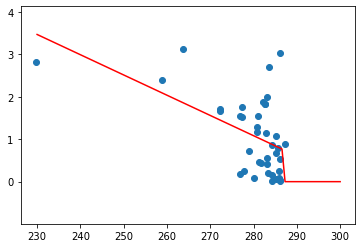

In [7]:
def f_model_MO(array,*args):
    if len(args)==1:
        params = args[0]
        [x_lim,a,b] = params
    elif len(args)==3:
        x_lim,a,b = args
    return np.where(array>x_lim,0,a*array+b)

def fit_model_MO(key,period_keys,plot=True):
    (sdk,edk) = period_keys
    rain_gt,val_images,locations = combine_gt_pixel_from_index(key,sdk=sdk,edk=edk)
    xdata,ydata = [],[]
    for i in range(len(rain_gt)):
        if (not np.isnan(val_images[i])) and (not np.isnan(rain_gt[i])) :
            xdata.append(val_images[i]) ; ydata.append(rain_gt[i])
    xlim = np.max(xdata)
    a = (xdata[0]-xdata[1])/(ydata[0]-ydata[1])
    b = ydata[0] - a*xdata[0]
    param_opt, pcov = curve_fit(f=f_model_MO,xdata=xdata,ydata=ydata,p0=(xlim,a,b))
    if plot:
        xsample = np.linspace(230, 300, 100)
        ysample = [f_model_MO(xsample[i],param_opt) for i in range(len(xsample))]

        plt.plot(xsample,ysample,color="red")
        plt.scatter(xdata,ydata)
        plt.ylim(ymin=np.min(ydata)-1,ymax=np.max(ydata)+1)
        plt.show()
    return param_opt

key = "SSMIS_tif_91V" ; period_keys = ("start_date_91V","end_date_91V")
param_opt = fit_model_MO(key,period_keys)

### à partir de la méthode RACC

In [9]:
def fit_model_RACC(N,model_param,agr_dir,seg_dir):
    array_pred,centers,legend = classification(agr_dir,seg_dir,projection,N=N,standardisation=True,epsilon=0.001,T=100,save=False,show=False)
    new_centers = np.zeros(np.shape(centers))
    idx_MO = np.argmax([("SSMIS" in leg) for leg in legend])
    idx_var = np.argmax([("var" in leg) for leg in legend])
    idx_IR = [i for i in range(len(legend)) if i not in [idx_var,idx_MO]][0]
    new_centers[:, 0] = centers[:, idx_IR]
    new_centers[:, 1] = centers[:, idx_var]
    new_centers[:, 2] = f_model_MO(centers.T[idx_MO],model_param)
    centers_fn = seg_dir+"/centers.npy"
    np.save(centers_fn,new_centers)
    return new_centers

def f_model_RACC(array,centers):
    array_var = compute_var(array)
    (nb_rows,nb_cols) = np.shape(array)
    rain_pred = np.zeros((nb_rows,nb_cols))
    for y in range(nb_rows):
        for x in range(nb_cols):
            c = np.argmin(np.sqrt((centers.T[0]-array[y][x])**2+(centers.T[1]-array_var[y][x])**2))
            rain_pred[y][x] = centers[c][2]
    return rain_pred

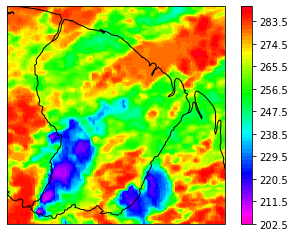

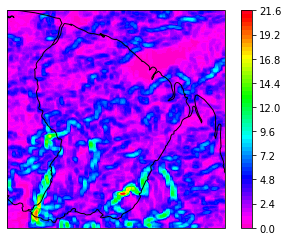

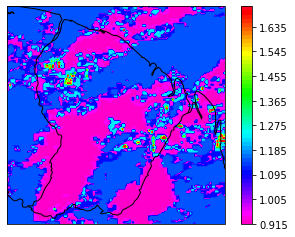

In [10]:
N = 20 ; key="SSMIS_tif_91V" ; 
param_opt = fit_model_MO(key,period_keys,plot=False)
centers = fit_model_RACC(N,param_opt,agr_dir,seg_dir)

fn = r"C:\Users\Baptiste\Documents\ENSG\stage\data\SEVIRI\MSG4-SEVI-MSG15-0100-NA-20211230201243.081000000Z-NA.nat"

image = File(fn).project(projection,"IR_087")
image.show()
var = image.computeVar()
var.show()
arr_result = f_model_RACC(image.array,centers)
rain_estim = Image(arr_result,image.lons,image.lats)
rain_estim.show()

### application du modèle

In [ ]:
def compute_rain_rate(key,f_model,params,out_dir=False,show=True):
    index = get_index(index_path)
    for d in index.keys(): # récupération des images
        try:
            image = File(index[d][key]).getImage(1)
            R = f_model(image.array,params)
            img_rain_rate = Image(R,image.lons,image.lats)
            if out_dir:
                filename = out_dir + rf"/rain_rate_{d[:10]}.tiff"
                img_rain_rate.save(projection,filename)
                index[d]["rain_rate"] = filename
                save_index(index,index_path)
            if show:
                img_rain_rate.show()
        except KeyError:
            print(f"l'un des fichiers correspondant à la date {d} n'a pas été trouvé")

compute_rain_rate("SEVIRI_IR_108_tif",f_model_RACC,centers,rr_dir)

## Comparaison images - vérité terrain

Ce module permet de comparer les images avec la vérité terrain en calculant les métriques associées



In [4]:
def compare_gt_pixel_values(ground_list,estim_list,indice_corr="Pearson",savefig=False,quiet=False):
    """
    Compare une liste d'estimation d'une valeur avec une liste vérité terrain
    Les métriques calcuées sont le coefficient de corrélation, le RMSE et le BIAS

    Args :
        ground_list (list) : liste des valeurs de vérité terrain
        estim_list (list) : liste des valeurs estimée
        indice_corr ("Pearson" ou "Spearman") : type du coefficient de corrélation calculé (Default "Pearson")
        savefig (Bool - string) : si non faux, enregistre la figure avec le chemin savefig

    Return :
        corr (float) : coefficient de corrélation
        RMSE (float) : Root Mean Square Error - moyenne des erreurs quadratiques
        BIAS (float) : biais
    """
    ground_list,estim_list = np.array(ground_list),np.array(estim_list)
    xmin,xmax,attributes = 260,290,False

    if indice_corr == "Pearson":
        corr, _ = pearsonr(ground_list, estim_list)
    elif indice_corr == "Spearman":
        corr, _ = spearmanr(ground_list, estim_list)
    RMSE = np.sqrt(np.sum((ground_list-estim_list)**2)/len(ground_list))
    BIAS = np.sum(estim_list-ground_list) / np.sum(ground_list)

    
    if attributes:
        color_list = ["red","green","blue","orange","yellow","pink","black","purple","beige","brown","gray","cyan"]
        colors = [color_list[np.where(np.unique(attributes)==loc)[0][0]] for loc in attributes]
        plt.scatter(ground_list,estim_list,c=colors,s=60, alpha=0.8)
        for i in range(len(np.unique(attributes))):
            print(color_list[i],"\t",np.unique(attributes)[i])
    else:
        plt.scatter(ground_list,estim_list,s=50,alpha=0.8)
    plt.grid()
    if savefig:
        plt.savefig(savefig, dpi=500)

    if not quiet:
        print(f"CC {indice_corr} = {round(corr,3)}")
        print(f"RMSE = {round(RMSE,3)}")
        print(f"BIAS = {round(BIAS,3)}")

        plt.show()

    return corr,RMSE,BIAS

In [ ]:
# test unitaire

savefig = r"../../rapports/images/rel_TBIR097-rain_0520.png"

#SEVIRI_IR_097_tif - SSMIS_tif_91V
key = "SSMIS_tif_91V"
true_rain,estim_rain,locations = combine_gt_pixel_from_index(key,edk="end_date_91V",sdk="start_date_91V")

compare_gt_pixel_values(true_rain,estim_rain,indice_corr="Spearman",savefig=False)

## Mise en place téléchargement et formattage des données

In [5]:
def main_formatting(image_name,start_period,end_period,attribute,nb_dates=False,shuffle=False):
    """
    Télécharge un certain nombre d'images sur la période donnée
    extrait la valeur de ses pixels avec la vérité terrain
    retourne un jeu de données formaté

    Args :
        image_name (string) : image dont on veut comparer les pixels
        start_period (datetime) : borne inférieur de la période étudiée
        end_period (datetime) : borne supérieure de la période étudiée
        attribute (string) : attribut de l'image à extraire
        f_model (bool ou function) : fonction à appliquer à l'image pour générer une estimation, compare l'image elle-même si False (Default False)
        nb_dates (Bool, int) : si entier, limite le nombre de dates générées (Default False)
        shuffle (Bool) : si vrai, mélange la liste des dates, si le nombre de dates est limité cela équivaut à un tirage aléatoire

    Return :
        final_df (pandas dataframe) : dataframe contenant l'ensemble des valeurs extraites
    """

    # initialisation du dataframe
    final_df = pd.DataFrame()

    # lecture et extraction du fichier de la vérité terrain entre les deux dates
    # pour obtenir la liste des dates
    gt_1h_df = pd.read_csv(gt_fn)
    rain_extr_df = gt.extract(gt_1h_df,start_period,end_period)
    rain_extr_df['time'] = pd.to_datetime(rain_extr_df['time'],utc=True) 
    rain_extr_df.set_index("time",inplace=True)
    rain_extr_df = rain_extr_df.resample("D").sum()

    # extraction des dates
    dates = rain_extr_df.index.array
    
    # tirage aléatoire des dates
    if shuffle:
        random.seed(70)
        random.shuffle(dates)
    
    # restriction à certaines dates
    if nb_dates:
        dates = dates[:nb_dates]
    
    # itération sur les dates
    for d in dates:
        result_df = download_and_combine(d,image_name,attribute)
        final_df = pd.concat([final_df,result_df],ignore_index=True)
        
    return final_df
    

def download_and_combine(d,image_name,attribute,cols=False):
    if image_name == "SEVIRI":
        result = download_SEVIRI_image(d,SEVIRI_src_dir,path_API_meteosat_keys)
    elif image_name == "SSMIS":
        result = download_SSMIS_image(d,SSMIS_src_dir,projection,SSMIS_parameters,path_API_nsidc_keys,quiet=True)
    elif image_name == "IMERG":
        result = download_IMERG_image(d,IMERG_src_dir,quiet=True)
    else:
        result = False
    
    if result == False:
        print(f"aucune image n'a pu être téléchargée pour la date {d}")
        return False
    else:
        (fn,start,end) = result
        # estimation de la pluie à partir du modèle appliqué à l'image
        result_df = combine_gt_pixel_from_image(fn,attribute,cols)
        return result_df
        
    

In [ ]:
# test unitaire

start_period = datetime(2019,1,1,tzinfo=timezone.utc)
end_period = start_period + timedelta(days=31)

main_formatting("SSMIS",start_period,end_period,"TB",nb_dates=5)

## main


### Téléchargement et préparation des données à analyser

In [18]:
start = datetime(2016,1,1,tzinfo=timezone.utc)
end = datetime(2020,12,31,tzinfo=timezone.utc)

image_name, attribute = "IMERG","HQprecipitation"

final_df = main_formatting(
    image_name=image_name,
    start_period=start,
    end_period=end,
    attribute=attribute,
    nb_dates=False
    )

final_df.to_csv(eval_dir + rf"/comparaison_{image_name}-VT_2016-2020.csv")

### Analyse des données

In [7]:
df_filename = eval_dir + rf"/comparaison_IMERG-VT_2016-2020.csv"
df = pd.read_csv(df_filename)
indice_corr = "Pearson"
df["month"] = pd.DatetimeIndex(df['date']).month

stat_df = pd.DataFrame(columns=["nb_points","corr","RMSE","BIAS","rain_mmean","rain_std","rain_median"])

CC Pearson = 0.665
RMSE = 14.668
BIAS = -0.798


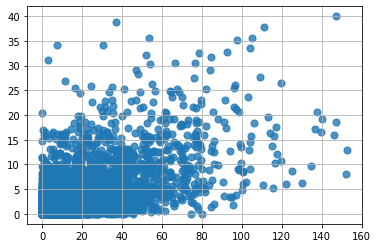

In [24]:
# comparaison de l'ensemble des données
true_rain,pixel_values = df["VT"].values,df["pixel"].values
savefig = eval_dir + rf"/comparaison_IMERG-VT_2016-2020.png"
corr,RMSE,BIAS = compare_gt_pixel_values(true_rain,pixel_values,indice_corr=indice_corr,savefig=savefig)

stat_df.loc["2016-2020"] = [len(true_rain),corr,RMSE,BIAS,np.mean(true_rain),np.std(true_rain),np.median(true_rain)]

In [ ]:
# comparaison par capteur
for captor_name in np.unique(df["nom capteur"].values):
    df_capt = df.loc[df["nom capteur"]==captor_name]
    true_rain,pixel_values = df_capt["VT"].values,df_capt["pixel"].values
    corr,RMSE,BIAS = compare_gt_pixel_values(true_rain,pixel_values,indice_corr=indice_corr,savefig=False,quiet=True)
    stat_df.loc[f"2016-2020_{captor_name}"] = [len(true_rain),corr,RMSE,BIAS,np.mean(true_rain),np.std(true_rain),np.median(true_rain)]

print(stat_df)

In [ ]:
# comparaison par mois
for month in range(1,13):
    df_month = df.loc[df["month"]==month]
    true_rain,pixel_values = df_month["VT"].values,df_month["pixel"].values
    corr,RMSE,BIAS = compare_gt_pixel_values(true_rain,pixel_values,indice_corr=indice_corr,savefig=False,quiet=True)
    stat_df.loc[f"2016-2020_month_{month}"] = [len(true_rain),corr,RMSE,BIAS,np.mean(true_rain),np.std(true_rain),np.median(true_rain)]

print(stat_df)

                            nb_points      corr       RMSE      BIAS  \
2016-2020_season_avril-mai     1930.0  0.704440  24.339352 -0.826533   
2016-2020_season_dec_jan       2023.0  0.664652  14.353495 -0.799021   
2016-2020_season_oct_nov       1974.0  0.619055   7.637677 -0.752944   

                            rain_mmean   rain_std  rain_median  
2016-2020_season_avril-mai   16.420052  23.235359          6.8  
2016-2020_season_dec_jan      8.520020  14.869154          2.5  
2016-2020_season_oct_nov      2.938956   8.369039          0.2  


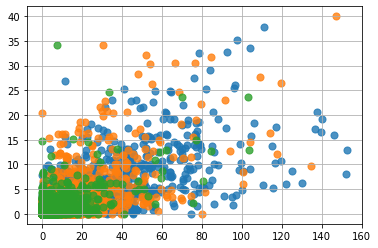

In [21]:
# comparaison par saison
seasons = {"avril-mai":[4,5],"dec_jan":[12,1],"sept_oct":[9,10]}
for s in seasons.keys():
    df_seasons = df.loc[(df.iloc[i]["month"] in seasons[s] for i in range(len(df)))]
    true_rain,pixel_values = df_seasons["VT"].values,df_seasons["pixel"].values
    corr,RMSE,BIAS = compare_gt_pixel_values(true_rain,pixel_values,indice_corr=indice_corr,savefig=False,quiet=True)
    stat_df.loc[f"2016-2020_season_{s}"] = [len(true_rain),corr,RMSE,BIAS,np.mean(true_rain),np.std(true_rain),np.median(true_rain)]
print(stat_df)

In [38]:
# Plan de Rodrigo
# séléction des capteurs de Kourou
df_Kourou = df.loc[(df.iloc[i]["id capteur"] in [97304001,97304003,97304005] for i in range(len(df)))]
# agrégation des données par date (moyenne)
df_Kourou['date'] = pd.to_datetime(df_Kourou['date'],utc=True) 
df_Kourou.set_index("date",inplace=True)
df_Kourou = df_Kourou.resample("D").mean()
df_Kourou=df_Kourou.dropna()
# calcul des résultats
true_rain,pixel_values = df_Kourou["VT"].values,df_Kourou["pixel"].values
corr,RMSE,BIAS = compare_gt_pixel_values(true_rain,pixel_values,indice_corr=indice_corr,savefig=False,quiet=True)
stat_df.loc[f"2016-2020 3stationsKourou"] = [len(true_rain),corr,RMSE,BIAS,np.mean(true_rain),np.std(true_rain),np.median(true_rain)]

print(stat_df)


0


C:\Users\Baptiste\AppData\Local\Temp\ipykernel_27792\3109663373.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Kourou['date'] = pd.to_datetime(df_Kourou['date'],utc=True)


'\n# calcul des résultats\ntrue_rain,pixel_values = df_Kourou["VT"].values,df_Kourou["pixel"].values\ncorr,RMSE,BIAS = compare_gt_pixel_values(true_rain,pixel_values,indice_corr=indice_corr,savefig=False,quiet=True)\nstat_df.loc[f"2016-2020 3stationsKourou"] = [len(true_rain),corr,RMSE,BIAS,np.mean(true_rain),np.std(true_rain),np.median(true_rain)]\n\nprint(stat_df)\n'

In [28]:
# sauvegarde des résultats
print(stat_df)
stat_df.to_csv(eval_dir + rf"/resultats_2016-2020.csv")

                            nb_points      corr       RMSE      BIAS  \
2016-2020                     11567.0  0.665208  14.668264 -0.797847   
2016-2020_CAYENNE—MATOURY      1825.0  0.724026  16.837758 -0.825235   
2016-2020_ILE ROYALE           1773.0  0.684481  15.464093 -0.782672   
2016-2020_KOUROU CSG           1782.0  0.646689  14.677670 -0.791213   
2016-2020_KOUROU PLAGE         1822.0  0.666632  14.434630 -0.766531   
2016-2020_MARIPASOULA           868.0  0.481270  10.273946 -0.765218   
2016-2020_SAINT GEORGES        1802.0  0.665119  15.568797 -0.829546   
2016-2020_SAINT LAURENT        1695.0  0.639808  12.275081 -0.785402   
2016-2020_month_1               973.0  0.681489  10.904217 -0.807472   
2016-2020_month_2               925.0  0.697596  12.904432 -0.821028   
2016-2020_month_3               998.0  0.669890  14.167054 -0.828368   
2016-2020_month_4               958.0  0.766928  23.947043 -0.826900   
2016-2020_month_5               972.0  0.632050  24.719919 -0.82